# Credit Card Default Classification Project



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Data

In [2]:
df = pd.read_csv('DATA/training_data.csv',  index_col = 0)
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
28835,220000,2,1,2,36,0,0,0,0,0,...,221193,181859,184605,10000,8018,10121,6006,10987,143779,1
25329,200000,2,3,2,29,-1,-1,-1,-1,-1,...,326,326,326,326,326,326,326,326,326,0
18894,180000,2,1,2,27,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning & EDA

It seems like there's a row that's supposed to be the header.

In [3]:
df = df.rename(columns = df.loc['ID'])
df = df.drop([df.index[0], 'ID'])


In [4]:
#df.info()

They are still all objects. Let's take a look at each of their unique values, if they don't have to be objects, I'll convert them.

In [5]:
#df.describe()

In [6]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [33]:
categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
for c in df.columns:
    if c not in categorical: 
        df[c] = pd.to_numeric(df[c])

#for c in df.columns[0:5]:
#    print (f"{c}: {df[c].unique()}")

### Credit Limit

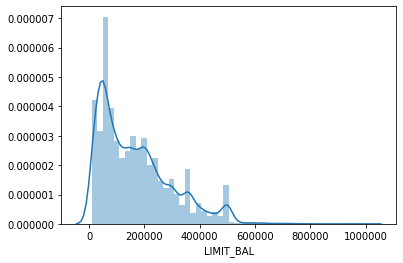

In [34]:
sns.distplot(df.LIMIT_BAL)

Some people seems to have very high credit limit, but nothing look abnormal.

### SEX

In [35]:
df.SEX.value_counts()

2    13571
1     8927
Name: SEX, dtype: int64

Data is a little skewed towards females.

### Education

In [36]:
df.EDUCATION.value_counts()

2    10516
1     7918
3     3713
5      208
4       90
6       42
0       11
Name: EDUCATION, dtype: int64

There are unknown values above 4. We can roughly assume that higher education is linked to higher credit limit. Let's see if this matches up with the number system. 

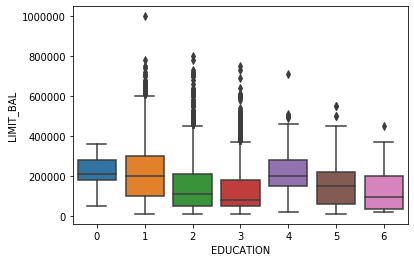

In [31]:
sns.boxplot(df.EDUCATION, df.LIMIT_BAL)

Okay, we cannot treat this as an ordinal group. We will treat as categorical.

### MARRIAGE

In [40]:
df.MARRIAGE.value_counts()

2    12025
1    10195
3      234
0       44
Name: MARRIAGE, dtype: int64

I'm guessing 0 values are ones we don't have the information for.

### Age

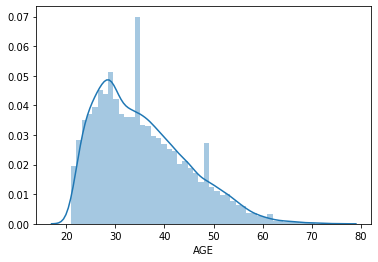

In [41]:
sns.distplot(df.AGE)

In [42]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

### History of past payment
PAY0 ~ 6 are past payment status backwards (from Sept ~ April).  
Repayment status measurement scale is...  
-1: paid ontime  
1: delayed for one month  
2: delayed for 2 months  ...  
8: delayed for 8 months  
9: delayed for nine + months  

I want to first see if there are no values I don't understand.

In [52]:
pay_hist_names =[c for c in df if c.startswith('PAY')][0:6]

In [56]:
df[pay_hist_names].apply(lambda x: x.unique())

PAY_0    [-1, -2, 0, 2, 1, 3, 8, 4, 6, 5, 7]
PAY_2    [-1, -2, 0, 2, 3, 4, 7, 5, 1, 8, 6]
PAY_3    [-1, -2, 0, 2, 3, 4, 6, 5, 7, 8, 1]
PAY_4    [-1, -2, 0, 2, 4, 5, 3, 7, 6, 8, 1]
PAY_5       [-1, -2, 0, 2, 4, 3, 7, 5, 6, 8]
PAY_6       [-1, -2, 0, 2, 4, 3, 7, 6, 8, 5]
dtype: object

Okay, there are 0 and -2, which are not the values we are supposed to have. We need to figure out what they mean by actually looking at the payment/bill amount. Let's check the amount of billing statement and the payment, first to make sure these data are free of errors.

### Amount of Billing Statement & Payment
BILL_AMT1 ~ 6 are also backward statement from September ~ April.  
PAY_AMT1~6 are previous payment from Sept ~ April.  